# Finetuning SAM 2 for Scientific Figures
This code is adapated from the following:
- [https://www.datacamp.com/tutorial/sam2-fine-tuning](https://www.datacamp.com/tutorial/sam2-fine-tuning)
- [https://learnopencv.com/finetuning-sam2/](https://learnopencv.com/finetuning-sam2/)
- [https://medium.com/data-science/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3](https://medium.com/data-science/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3)

In [1]:
import os
import json
import random 

import pandas as pd 
import numpy as np

import cv2
import torch
import torch.nn.utils
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

from tqdm.notebook import tqdm

In [2]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
 
set_seeds()

In [3]:
def read_jsons(input_dir):
    json_files = [
        pos_json for pos_json in os.listdir(input_dir) if pos_json.endswith(".json")
    ]
    output = [{}] * len(json_files)

    # get the image and bounding box
    for index, file in enumerate(json_files):  # [0:1]:
        with open(os.path.join(input_dir, file), "r") as input_file:
            data = json.load(input_file)
            output[index] = {
                "document": data["shapes"][0]["image_name"],
                "component_name": data["name"],
                "image": data["origin_image"],
                "bounding_box": data["shapes"][0]["points"],
            }

            # DEBUGGING
            # if data["origin_image"] == "./dataset/image/W19-6501-Figure4-1.png":
            #     print(index)
            #     print(output[index])
            #     print(file)

    return output


def plot_image_with_bounding_box(data):
    image_path = data["image"]
    bbox_coords = data["bounding_box"][0]  # Assuming one polygon
    component_name = data["component_name"]

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Load the image
    img = mpimg.imread(image_path)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("on")

    # Plot image with bounding box
    axs[1].imshow(img)
    axs[1].set_title("Image with Bounding Box")

    # Create a polygon patch
    polygon = patches.Polygon(
        bbox_coords, closed=True, edgecolor="red", linewidth=2, facecolor="none"
    )
    axs[1].add_patch(polygon)

    # Optionally annotate the component name at the top-left of the bounding box
    x, y = bbox_coords[0]
    axs[1].text(
        x,
        y - 10,
        component_name,
        color="red",
        fontsize=12,
        path_effects=[PathEffects.withStroke(linewidth=2, foreground="white")],
    )

    axs[1].axis("on")
    plt.tight_layout()
    plt.show()


def convert_box_to_mask(data):
    img = cv2.imread(data["image"])
    box = np.array(data["bounding_box"][0])
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, pts=[box], color=(255, 0, 0))
    return mask


In [4]:
data_dir = "./dataset/"
train_metadata = os.path.join(data_dir, "train")
val_metadata = os.path.join(data_dir, "val")
images_dir = os.path.join(data_dir, "image")

In [5]:
# TODO: verify training data is completely separate from valiation and testing data
train_data = read_jsons(train_metadata)
val_data = read_jsons(val_metadata)

print(f"Number training datapoints: {len(train_data)}")
print(f"Number validation datapoints: {len(val_data)}")

print(f"Number unique figures for training: {len(set([x['image'] for x in train_data]))}")
print(f"Number unique figures for validation: {len(set([x['image'] for x in val_data]))}")

Number training datapoints: 13761
Number validation datapoints: 1000
Number unique figures for training: 9770
Number unique figures for validation: 969


In [6]:
train_data[0]

{'document': '202401243.png',
 'component_name': 'Document Ranker',
 'image': './dataset/image/N18-4017-Figure1-1.png',
 'bounding_box': [[[357, 144], [357, 206], [443, 205], [442, 144]]]}

In [7]:
val_data[0]

{'document': '202406745.png',
 'component_name': 'Transformers',
 'image': './dataset/image/2021.bionlp-1.20-Figure2-1.png',
 'bounding_box': [[[199, 85],
   [199, 121],
   [201, 125],
   [530, 125],
   [533, 122],
   [533, 85],
   [529, 82],
   [202, 82]]]}

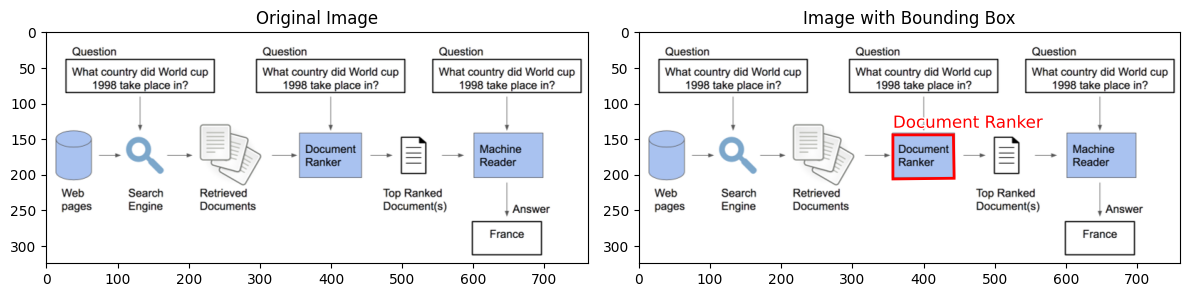

In [8]:
plot_image_with_bounding_box(train_data[0])

In [9]:
def read_batch(data, visualize_data=False):
    ent = data[np.random.randint(len(data))]
    Img = cv2.imread(ent["image"])[...,::-1]
    ann_map = convert_box_to_mask(ent)

    if Img is None or ann_map is None:
        print(
            f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}"
        )
        return None, None, None, 0

    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(
        ann_map,
        (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),
        interpolation=cv2.INTER_NEAREST,
    )

    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    inds = np.unique(ann_map)[1:]
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)
        binary_mask = np.maximum(binary_mask, mask)

    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])
    points = np.array(points)

    if visualize_data:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(Img)
        plt.axis("on")

        plt.subplot(1, 3, 2)
        plt.title("Binarized Mask")
        plt.imshow(binary_mask, cmap="gray")
        plt.axis("on")

        plt.subplot(1, 3, 3)
        plt.title("Binarized Mask with Points")
        plt.imshow(binary_mask, cmap="gray")
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
        plt.axis("on")

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)
    return Img, binary_mask, points, len(inds), ent


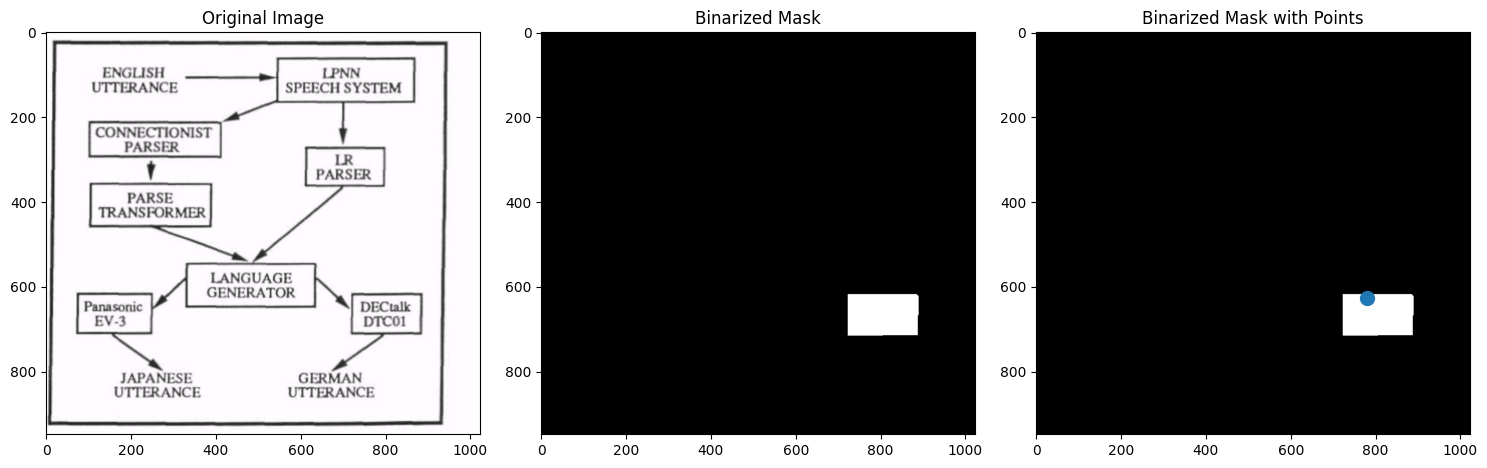

In [10]:
Img1, masks1, points1, num_masks, image_info = read_batch(train_data, visualize_data=True)

In [11]:
def train(predictor, train_data, step, mean_iou):
    with torch.amp.autocast(device_type="cuda"):
        image, mask, input_point, num_masks, image_info = read_batch(
            train_data, visualize_data=False
        )

        if image is None or mask is None or num_masks == 0:
            print("Image or Mask was None")
            return None, None, None, image_info

        input_label = np.ones((num_masks, 1))

        if not isinstance(input_point, np.ndarray) or not isinstance(
            input_label, np.ndarray
        ):
            print("Input label not the right type")
            return None, None, None, image_info

        if input_point.size == 0 or input_label.size == 0:
            print("Input not a coordinate")
            return None, None, None, image_info

        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )

        if (
            unnorm_coords is None
            or labels is None
            or unnorm_coords.shape[0] == 0
            or labels.shape[0] == 0
        ):
            print("Prompt could not be prepared")
            return None, None, None, image_info

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [
            feat_level[-1].unsqueeze(0)
            for feat_level in predictor._features["high_res_feats"]
        ]

        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(
            low_res_masks, predictor._orig_hw[-1]
        )

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])

        seg_loss = (
            -gt_mask * torch.log(prd_mask + 1e-6)
            - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)
        ).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        scheduler.step()

        # save model
        if step % 1000 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".pt"
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        try:
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        except Exception as e:
          print(f"An unexpected error occurred: {e}")
          print(
            f"Loss was None -- Image: {train_data['document']} Metadata: {train_data['document']}"
          )

        current_lr = optimizer.param_groups[0]["lr"]
    return mean_iou, current_lr, seg_loss, image_info


In [12]:
class FigureDataset(Dataset):
    def __init__(self, list_of_items):
        self.items = list_of_items

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]

def read_batch_validate(batch_of_dicts):
    """
    batch_of_dicts: list of dicts, length = batch_size
    Returns:
      images:    np.ndarray [B, H_max, W_max, 3]
      masks:     np.ndarray [B, 1, H_max, W_max]
      pts_list:  list of length B, each an [Ni,1,2] array
      n_masks:   list of length B
      infos:     list of original dicts
    """
    imgs, msks, pts_list, n_masks, infos = [], [], [], [], []
    heights, widths = [], []

    # 1) load & preprocess each sample, record its size
    for ent in batch_of_dicts:
        Img = cv2.imread(ent["image"])[..., ::-1]
        ann_map = convert_box_to_mask(ent)
        if Img is None or ann_map is None:
            print(f"Error reading {ent['image']}")
            continue

        # resize to fit within 1024×1024
        r = min(1024/Img.shape[1], 1024/Img.shape[0])
        new_w, new_h = int(Img.shape[1]*r), int(Img.shape[0]*r)
        Img = cv2.resize(Img, (new_w, new_h))
        ann_map = cv2.resize(ann_map, (new_w, new_h),
                             interpolation=cv2.INTER_NEAREST)

        # build binary mask
        binary_mask = np.zeros_like(ann_map, np.uint8)
        labels = np.unique(ann_map); labels = labels[labels != 0]
        for lbl in labels:
            binary_mask = np.maximum(binary_mask,
                                     (ann_map == lbl).astype(np.uint8))

        # pick one random point per region
        eroded = cv2.erode(binary_mask, np.ones((5,5),np.uint8), 1)
        coords = np.argwhere(eroded > 0)
        pts = []
        for _ in labels:
            if len(coords):
                y, x = coords[np.random.randint(len(coords))]
                pts.append([x, y])
        pts = np.array(pts, np.int32)[:, None, :]  # [Ni,1,2]

        imgs.append(Img)
        msks.append(binary_mask[None, ...])  # [1,H,W]
        pts_list.append(pts)
        n_masks.append(len(labels))
        infos.append(ent)
        heights.append(Img.shape[0])
        widths.append(Img.shape[1])

    # 2) pad all to common size
    H_max, W_max = max(heights), max(widths)
    padded_imgs, padded_msks = [], []
    for img, m in zip(imgs, msks):
        h, w = img.shape[:2]
        pad_img = np.zeros((H_max, W_max, 3), dtype=img.dtype)
        pad_img[:h, :w] = img
        padded_imgs.append(pad_img)

        pad_m = np.zeros((1, H_max, W_max), dtype=m.dtype)
        pad_m[:, :h, :w] = m
        padded_msks.append(pad_m)

    images = np.stack(padded_imgs, axis=0)   # [B,H_max,W_max,3]
    masks  = np.stack(padded_msks, axis=0)   # [B,1,H_max,W_max]
    return images, masks, pts_list, n_masks, infos

def validate(
    predictor,
    optimizer,
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    device="cuda",
):
    val_loader = DataLoader(
        FigureDataset(test_data),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=read_batch_validate
    )

    predictor.model.eval()
    total_loss = 0.0
    total_iou  = 0.0
    total_batches = 0

    with torch.no_grad(), torch.amp.autocast(device_type=device):
        for images_np, masks_np, pts_list, n_masks, infos in val_loader:
            # Keep images as NumPy for set_image(); convert masks to torch
            gt_masks = torch.from_numpy(masks_np).to(device, dtype=torch.float32)
            B = gt_masks.size(0)
            batch_losses, batch_ious = [], []

            for i in range(B):
                # feed the original H×W×3 NumPy image to predictor
                predictor.set_image(images_np[i])
                gt_mask = gt_masks[i, 0]  # [H,W]

                pts = pts_list[i]
                labels = np.ones((n_masks[i], 1), dtype=np.int32)

                # prepare prompts
                mask_input, unnorm_coords, lbls, _ = predictor._prep_prompts(
                    pts, labels, box=None, mask_logits=None, normalize_coords=True
                )
                if unnorm_coords is None or lbls is None:
                    continue

                # encode & decode
                sp_emb, dn_emb = predictor.model.sam_prompt_encoder(
                    points=(unnorm_coords, lbls), boxes=None, masks=None
                )
                high_res = [
                    lvl[-1].unsqueeze(0)
                    for lvl in predictor._features["high_res_feats"]
                ]
                low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sp_emb,
                    dense_prompt_embeddings=dn_emb,
                    multimask_output=True,
                    repeat_image=False,
                    high_res_features=high_res,
                )

                # upsample to original size
                prd_masks = predictor._transforms.postprocess_masks(
                    low_res_masks, predictor._orig_hw[-1]
                )
                prd_mask = torch.sigmoid(prd_masks[:, 0])  # [H,W]

                # segmentation loss
                seg_loss = (
                    -gt_mask * torch.log(prd_mask + 1e-6)
                    - (1 - gt_mask) * torch.log(1 - prd_mask + 1e-6)
                ).mean()

                # IoU & score loss
                inter = (gt_mask * (prd_mask > 0.5)).sum((-1, -2))
                union = (
                    gt_mask.sum((-1, -2))
                    + (prd_mask > 0.5).sum((-1, -2))
                    - inter
                )
                iou = inter / (union + 1e-6)
                score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

                loss = seg_loss + 0.05 * score_loss
                batch_losses.append(loss.item())
                batch_ious.append(iou.mean().item())

            if batch_losses:
                total_loss += sum(batch_losses) / len(batch_losses)
                total_iou  += sum(batch_ious)   / len(batch_ious)
                total_batches += 1

    avg_loss = total_loss / max(1, total_batches)
    avg_iou  = total_iou  / max(1, total_batches)
    current_lr = optimizer.param_groups[0]["lr"]

    return {
        "avg_loss": avg_loss,
        "avg_iou":  avg_iou,
        "lr":       current_lr,
        "batches":  total_batches,
    }


In [ ]:
# Load SAM Model and prepare for training
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml"
 
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

predictor.model.image_encoder.train(True) # requires commenting out no_grad in SAM 2 to prevent gradient collection
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

scaler = torch.amp.GradScaler()
NO_OF_STEPS = 40000
FINE_TUNED_MODEL_NAME = "./finetuned-models/fine_tuned_sam2"
 
optimizer = torch.optim.AdamW(params=predictor.model.parameters(),
                              lr=0.00005,
                              weight_decay=0.001)
 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.6)
accumulation_steps = 16

# store training output
train_output = [{}] * NO_OF_STEPS
train_mean_iou = 0
validation_output = []

output_str = ""
for step in tqdm(range(1, NO_OF_STEPS + 1)):
    new_train_mean_iou, train_lr, train_seg_loss, train_image_info = train(predictor, train_data, step, train_mean_iou)

    if new_train_mean_iou is not None:
        train_mean_iou = new_train_mean_iou

    # track iou and loss
    if all(v is not None for v in [train_lr, train_seg_loss, validation_output]):
        # update output
        train_output[step - 1] = {
            "mean_iou": float(train_mean_iou),
            "train_lr": train_lr,
            "seg_loss": float(train_seg_loss.item()),
        }

        # print status
        output_str = f"Train: {train_image_info['document']} / {train_image_info['image']}"
        if step % 500 == 0:
            print(f"Training: Step {step} | Current LR = {train_lr:.6f} | Avg IoU = {train_mean_iou:.6f} | Avg Seg Loss = {train_seg_loss:.6f}")

    # run validation every 1000 steps
    if step % 500 == 0:
        curr_validation_output = validate(predictor, optimizer, val_data, batch_size=len(val_data))
        validation_output.append(curr_validation_output)
        print(f"Validation: Avg IoU = {curr_validation_output['avg_iou']:.6f}, Avg Loss = {curr_validation_output['avg_loss']:.6f}")
        
    print(
        "{:<300}".format(output_str), end='\r'
    )

In [28]:
print(f"Training: Step {step} | Current LR = {train_lr:.6f} | Avg IoU = {train_mean_iou:.6f} | Avg Seg Loss = {train_seg_loss:.6f}")
print(f"Validation: Avg IoU = {curr_validation_output['avg_iou']:.6f}, Avg Loss = {curr_validation_output['avg_loss']:.6f}")

Training: Step 40000 | Current LR = 0.000000 | Avg IoU = 0.926311 | Avg Seg Loss = 0.000531
Validation: Avg IoU = 0.929027, Avg Loss = 0.018212


In [19]:
with open(f'./finetuned-models/training-log_sam2.1_hiera_large_{NO_OF_STEPS}-epochs_2000-step_06-gamma_{accumulation_steps}-acc.json', 'w') as f:
    json.dump(train_output, f)

with open(f'./finetuned-models/validation-log_sam2.1_hiera_large_{NO_OF_STEPS}-epochs_2000-step_06-gamma_{accumulation_steps}-acc.json', 'w') as f:
    json.dump(validation_output, f)

### Plot Loss

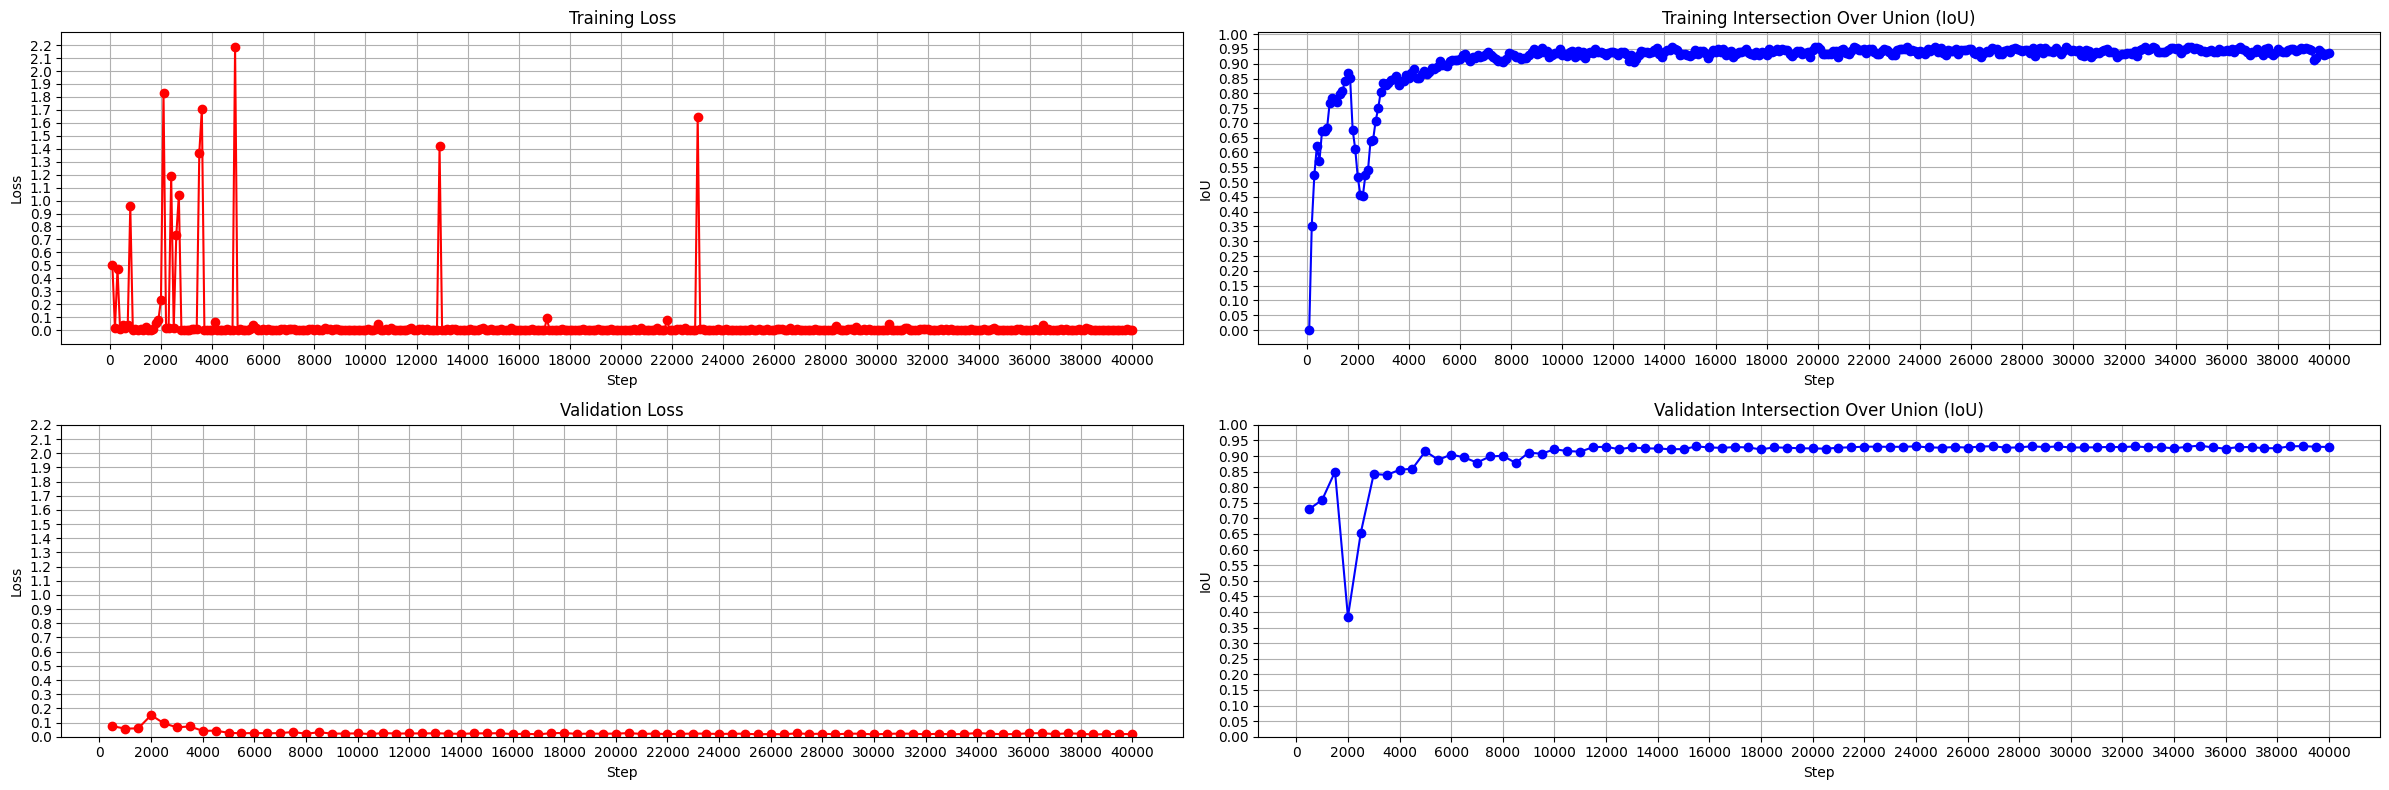

In [23]:
# Extract values
train_loss = [entry['seg_loss'] for entry in train_output if len(entry) > 0][::100]
train_iou = [entry['mean_iou'] for entry in train_output if len(entry) > 0][::100]

val_loss = [entry['avg_loss'] for entry in validation_output]
val_iou = [entry['avg_iou'] for entry in validation_output]

# Plotting
epochs_train = [x * 100 for x in list(range(1, len(train_loss) + 1))]
epochs_val = [x * 500 for x in list(range(1, len(val_loss)+1))]

# Create subplots in 2 rows, 2 columns
fig, axs = plt.subplots(2, 2, figsize=(24, 8))
x_ticks = np.arange(0, NO_OF_STEPS + 1, 2000)

# Top row: Training
axs[0, 0].plot(epochs_train, train_loss, label='Train Loss', marker='o', color='red')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Step')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_xticks(x_ticks)
axs[0, 0].set_yticks(np.arange(0, max(max(train_loss), max(val_loss)) + 0.1, 0.1))

axs[0, 1].plot(epochs_train, train_iou, label='Train IoU', marker='o', color='blue')
axs[0, 1].set_title('Training Intersection Over Union (IoU)')
axs[0, 1].set_xlabel('Step')
axs[0, 1].set_ylabel('IoU')
axs[0, 1].grid(True)
axs[0, 1].set_xticks(x_ticks)
axs[0, 1].set_yticks(np.arange(0, max(max(max(val_iou), max(train_iou)), 1) + 0.01, 0.05))

# Bottom row: Validation
axs[1, 0].plot(epochs_val, val_loss, label='Validation Loss', marker='o', color='red')
axs[1, 0].set_title('Validation Loss')
axs[1, 0].set_xlabel('Step')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_xticks(x_ticks)
axs[1, 0].set_yticks(np.arange(0, max(max(train_loss), max(val_loss)) + 0.1, 0.1))

axs[1, 1].plot(epochs_val, val_iou, label='Validation IoU', marker='o', color='blue')
axs[1, 1].set_title('Validation Intersection Over Union (IoU)')
axs[1, 1].set_xlabel('Step')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].grid(True)
axs[1, 1].set_xticks(x_ticks)
axs[1, 1].set_yticks(np.arange(0, max(max(max(val_iou), max(train_iou)), 1) + 0.01, 0.05))

plt.tight_layout()
plt.show()

## Check model against test set

In [24]:
test_metadata = os.path.join(data_dir, "test")
test_data = read_jsons(test_metadata)

print(f"Number testing datapoints: {len(test_data)}")
print(f"Number unique figures for training: {len(set([x['image'] for x in test_data]))}")

Number testing datapoints: 1000
Number unique figures for training: 980


In [25]:
test_data[0]

{'document': '202405001.png',
 'component_name': 'Refresh OLiA',
 'image': './dataset/image/L16-1707-Figure4-1.png',
 'bounding_box': [[[68, 787],
   [68, 797],
   [71, 801],
   [71, 807],
   [87, 822],
   [196, 822],
   [199, 819],
   [205, 817],
   [214, 805],
   [214, 780],
   [200, 766],
   [195, 766],
   [193, 764],
   [92, 764],
   [85, 766],
   [81, 770],
   [77, 771],
   [75, 776],
   [71, 780],
   [70, 786]]]}

In [26]:
test_validation = validate(predictor, optimizer, test_data, batch_size=len(test_data))
print(f"Test Set Validation: Batches {curr_validation_output['batches']} | Avg IoU = {test_validation['avg_iou']:.6f} | Avg Loss = {test_validation['avg_loss']:.6f}")

Test Set Validation: Batches 1 | Avg IoU = 0.935808 | Avg Loss = 0.013602
